# Use data from map to analyze charging station location pattern

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.metrics.regression import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

import os
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
os.chdir('/Users/chengchen/Desktop/Insight/project/')

In [85]:
shp_path = 'data/processed/shape_join_points.shp'
df_TRT_shp = gpd.read_file(shp_path)
df_TRT_shp.head()


,CTNAME,L_AREA,pop_den,testing,charging s,food court,gas statio,grocery st,parking lo,restaurant,shopping c,university,has_food_c,has chargi,geometry
0,0001.00,6.10,93.606557,647.0,2.0,1.0,4.0,3.0,6.0,3.0,0.0,0.0,1,1,"POLYGON ((-79.30393646966425 43.6643272879132,..."
1,0002.00,3.17,197.791798,323.0,0.0,1.0,0.0,0.0,5.0,8.0,0.0,0.0,1,0,(POLYGON ((-79.35299366051618 43.6340798358691...
2,0003.00,0.00,0.000000,91.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0,0,POLYGON ((-79.44798780649035 43.63842780120127...
3,0004.00,0.34,20179.411765,34.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0,POLYGON ((-79.43598377543616 43.63717191192797...
4,0005.00,0.38,13392.105263,37.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0,0,POLYGON ((-79.42138741235314 43.64066395144786...


In [107]:
df_TRT_shp['chg_den'] = df_TRT_shp['charging s']/df_TRT_shp['L_AREA']
df_TRT_shp.loc[df_TRT_shp['chg_den'].isnull(),'chg_den'] = 0
df_TRT_shp.describe()


,L_AREA,pop_den,testing,charging s,food court,gas statio,grocery st,parking lo,restaurant,shopping c,university,has_food_c,has chargi,chg_den
count,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000
mean,1.487450,6548.035175,116.754098,0.264117,0.588342,0.828780,1.642987,2.462659,3.774135,0.581056,0.373406,0.207650,0.118397,0.243946
std,3.646177,5807.335988,154.674085,1.107953,1.968254,1.697951,2.101453,4.296171,6.392570,1.312241,2.652107,0.405995,0.323372,1.136139
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.520000,3131.884058,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.880000,5121.698113,77.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.400000,8310.294118,127.000000,0.000000,0.000000,1.000000,2.000000,3.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,55.690000,63765.217391,1877.000000,15.000000,19.000000,23.000000,16.000000,56.000000,71.000000,11.000000,51.000000,1.000000,1.000000,17.021277


* There are many more CTs with charging stations then without. Therefore I will undersample those without to create a balanced training/validation set.

In [108]:
df_CT_chg = df_TRT_shp[df_TRT_shp['has chargi']==1] # the variable name was shortened during saving/reading gpd

In [109]:
df_CT_no_chg = df_TRT_shp[df_TRT_shp['has chargi']==0]

In [110]:
df_CT_chg.shape

(65, 16)

In [111]:
df_CT_no_chg.shape

(484, 16)

In [112]:
df_CT_no_chg_undersample = df_CT_no_chg.sample(n=65)

In [113]:
df_train_test = df_CT_chg.append(df_CT_no_chg_undersample)

In [114]:
df_train_test.shape

(130, 16)

The sample size might be too small to use Random Forest.  
Let's just try linear regression for now.

In [116]:
X = df_train_test[['pop_den','has_food_c','gas statio', 'grocery st','parking lo', 'restaurant', 'shopping c', 'university']]
y = df_train_test['chg_den']# y: density of charging station
log_X = X.add(1).apply(np.log)
log_X

,pop_den,has_food_c,gas statio,grocery st,parking lo,restaurant,shopping c,university
0,4.549727,0.693147,1.609438,1.386294,1.945910,1.386294,0.000000,0.000000
12,8.463314,0.693147,1.098612,1.386294,2.708050,2.639057,1.098612,0.693147
13,8.889578,0.693147,0.000000,1.791759,1.945910,0.693147,1.098612,0.000000
14,9.025240,0.693147,0.693147,2.639057,2.833213,2.302585,0.000000,0.693147
15,7.062155,0.693147,0.000000,1.609438,2.564949,2.079442,2.197225,1.609438
16,9.189511,0.693147,0.000000,1.098612,2.772589,2.995732,0.000000,0.693147
17,8.808898,0.693147,1.609438,1.098612,2.484907,2.484907,0.693147,1.098612
18,8.475639,0.000000,0.000000,1.386294,2.708050,2.079442,0.693147,0.000000
19,8.442069,0.000000,0.693147,0.000000,0.000000,0.693147,0.000000,0.000000
31,9.390550,0.000000,0.000000,0.000000,0.693147,1.098612,0.693147,0.000000


In [117]:
log_y = y.add(1).apply(np.log)
log_y

0      0.283575
12     1.625633
13     1.526839
14     1.598856
15     2.891553
16     1.519826
17     1.700669
18     1.388172
19     1.349927
31     1.834685
32     1.578185
36     2.148939
37     1.289668
39     1.329136
40     1.417066
51     1.154965
65     2.311635
69     1.834685
95     1.676690
96     1.954531
132    1.466337
135    1.024504
142    1.147573
148    0.870828
174    0.950615
211    0.362336
228    0.631539
242    0.730091
274    0.108803
275    0.268990
         ...   
366    0.000000
130    0.000000
369    0.000000
360    0.000000
264    0.000000
186    0.000000
35     0.000000
363    0.000000
258    0.000000
450    0.000000
231    0.000000
445    0.000000
405    0.000000
118    0.000000
308    0.000000
359    0.000000
479    0.000000
304    0.000000
413    0.000000
152    0.000000
193    0.000000
176    0.000000
154    0.000000
179    0.000000
225    0.000000
410    0.000000
428    0.000000
73     0.000000
61     0.000000
138    0.000000
Name: chg_den, dtype: fl

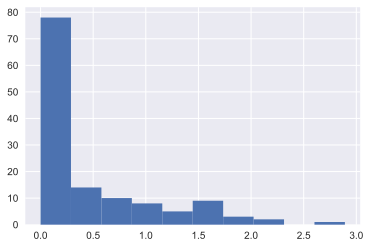

In [118]:
log_y.hist()

In [119]:
model = LinearRegression().fit(log_X, log_y)
r_sq = model.score(log_X, log_y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 0.4010535418747804
intercept: -1.380600821697501
slope: [ 0.18079354  0.42079863 -0.16371736  0.00723617  0.22618985 -0.06808101
  0.19569003  0.14089728]


In [120]:
log_X_all = df_TRT_shp[['pop_den','has_food_c','gas statio', 'grocery st','parking lo', 'restaurant', 'shopping c', 'university']].add(1).apply(np.log)
df_TRT_shp['predict_log_y'] = model.predict(log_X_all)

In [123]:
df_TRT_shp['predict_chg_den'] = np.exp(df_TRT_shp['predict_log_y'])-1


In [124]:
# if predicted negative number of charging stations, replace to 0
df_TRT_shp.loc[df_TRT_shp['predict_chg_den']<0,'predict_chg_den'] = 0
df_TRT_shp[['chg_den','predict_chg_den']]

,chg_den,predict_chg_den
0,0.327869,0.000000
1,0.000000,0.131528
2,0.000000,0.000000
3,0.000000,0.446772
4,0.000000,0.533154
5,0.000000,0.440481
6,0.000000,0.479344
7,0.000000,0.696273
8,0.000000,1.160816
9,0.000000,0.000000


In [125]:
df_TRT_shp.head()

,CTNAME,L_AREA,pop_den,testing,charging s,food court,gas statio,grocery st,parking lo,restaurant,shopping c,university,has_food_c,has chargi,geometry,chg_den,predict_log_y,predict_chg_den
0,0001.00,6.10,93.606557,647.0,2.0,1.0,4.0,3.0,6.0,3.0,0.0,0.0,1,1,"POLYGON ((-79.30393646966425 43.6643272879132,...",0.327869,-0.174061,0.000000
1,0002.00,3.17,197.791798,323.0,0.0,1.0,0.0,0.0,5.0,8.0,0.0,0.0,1,0,(POLYGON ((-79.35299366051618 43.6340798358691...,0.000000,0.123569,0.131528
2,0003.00,0.00,0.000000,91.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0,0,POLYGON ((-79.44798780649035 43.63842780120127...,0.000000,-0.940456,0.000000
3,0004.00,0.34,20179.411765,34.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0,POLYGON ((-79.43598377543616 43.63717191192797...,0.000000,0.369335,0.446772
4,0005.00,0.38,13392.105263,37.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0,0,POLYGON ((-79.42138741235314 43.64066395144786...,0.000000,0.427327,0.533154


* show on shapefile for the actual and prediction 

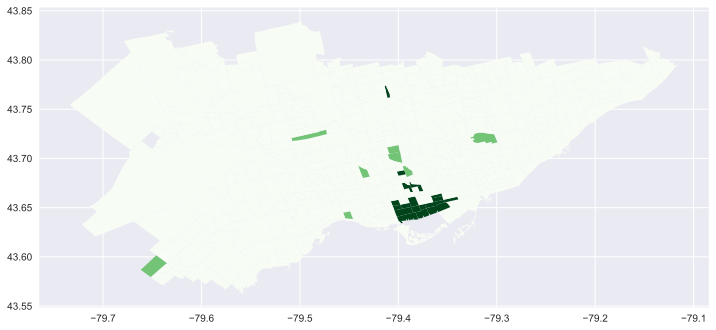

In [132]:
df_TRT_shp.plot(figsize=(12,10),column='chg_den',cmap='Greens', scheme='std_mean')
plt.savefig('graphs/current_chg_stn.pdf')


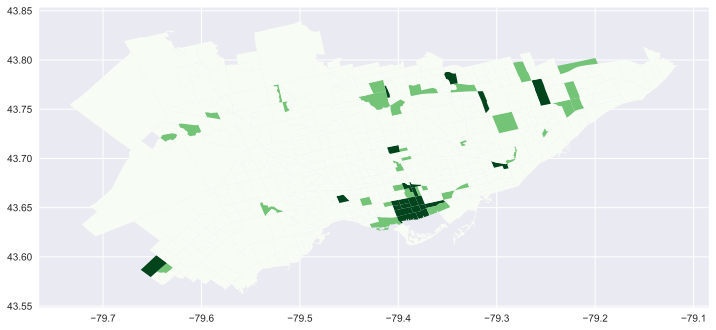

In [131]:
df_TRT_shp.plot(figsize=(12,10),column='predict_chg_den',cmap='Greens', scheme='std_mean')
plt.savefig('graphs/predict_chg_den.pdf')
